[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cloudbed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cloudbed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cloudbed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


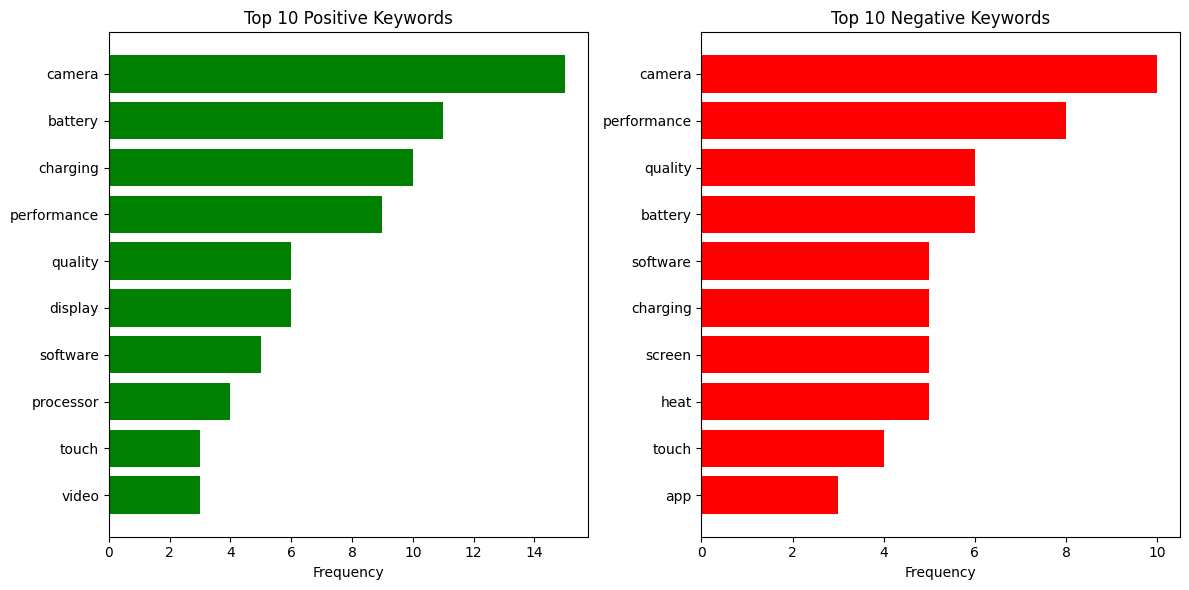

Top 10 keywords saved to 'top_10_keywords.txt'.
Results saved to 'comments_with_classified_keywords.csv'.


In [3]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text function (improved for better cleaning)
def preprocess_text(text):
    # Lowercase and remove extra characters
    if pd.isnull(text):  # Check if the text is NaN
        return ''  # Return an empty string if it is NaN
    # Lowercase and remove extra characters
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization (to capture root forms of words)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

# Load keywords from file
def load_keywords(file_path='keywords.txt'):
    with open(file_path, 'r') as file:
        keywords = file.read().splitlines()  # Read keywords and split lines
    return keywords

# Keyword matching function with fuzzy and partial matching
def match_keywords(comment, keywords, fuzz_threshold=80):
    cleaned_comment = preprocess_text(comment)
    matched_keywords = []
    comment_words = set(cleaned_comment.split())  # Split the cleaned comment
    
    for keyword in keywords:
        keyword = keyword.lower()
        
        # Check for exact match of full keyword (multi-word match)
        if re.search(r'\b' + re.escape(keyword) + r'\b', cleaned_comment):
            matched_keywords.append(keyword)
        else:
            # Partial word match (match parts of the keyword)
            keyword_parts = keyword.split()
            for part in keyword_parts:
                if part in comment_words:
                    matched_keywords.append(part)
            
            # Fuzzy matching for minor variations
            fuzzy_match = process.extractOne(cleaned_comment, [keyword], scorer=fuzz.partial_ratio)
            if fuzzy_match and fuzzy_match[1] >= fuzz_threshold:
                matched_keywords.append(fuzzy_match[0])
    
    return list(set(matched_keywords))  # Return unique matches

# Function to classify keywords into positive/negative
def classify_keywords(df, keywords):
    # Apply keyword matching and classify as positive/negative
    df['matched_keywords'] = df['Content'].apply(lambda x: match_keywords(x, keywords))
    
    # Create a new column 'sentiment' where we classify positive and negative reviews
    def classify_sentiment(rating):
        if rating >= 4:
            return 'Positive'
        else:
            return 'Negative'


    # Apply the function to the 'rating' column
    df['sentiment'] = df['Rating'].apply(classify_sentiment)




    # Separate positive and negative comments
    positive_df = df[df['sentiment'] == 'Positive']
    negative_df = df[df['sentiment'] == 'Negative']
    
    positive_keywords = [kw for sublist in positive_df['matched_keywords'] for kw in sublist]
    negative_keywords = [kw for sublist in negative_df['matched_keywords'] for kw in sublist]
    
    return positive_keywords, negative_keywords

# Visualization of keyword frequency
def plot_keyword_frequency(positive_keywords, negative_keywords):
    positive_counts = Counter(positive_keywords)
    negative_counts = Counter(negative_keywords)
    
    # Plot positive keywords
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    common_positive = positive_counts.most_common(10)  # Top 10 positive
    plt.barh([kw[0] for kw in common_positive], [kw[1] for kw in common_positive], color='green')
    plt.xlabel('Frequency')
    plt.title('Top 10 Positive Keywords')
    plt.gca().invert_yaxis()

    # Plot negative keywords
    plt.subplot(1, 2, 2)
    common_negative = negative_counts.most_common(10)  # Top 10 negative
    plt.barh([kw[0] for kw in common_negative], [kw[1] for kw in common_negative], color='red')
    plt.xlabel('Frequency')
    plt.title('Top 10 Negative Keywords')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

# Read CSV file (assuming it's named 'reviews.csv')
df = pd.read_csv('reviews.csv')

# Load keywords from file
keywords = load_keywords('keywords.txt')

# Classify and extract positive and negative keywords
positive_keywords, negative_keywords = classify_keywords(df, keywords)

# Visualize the keyword frequencies
plot_keyword_frequency(positive_keywords, negative_keywords)



# Count the frequency of each keyword
positive_keyword_counts = Counter(positive_keywords)
negative_keyword_counts = Counter(negative_keywords)

# Get top 10 positive and negative keywords
top_10_positive = positive_keyword_counts.most_common(10)
top_10_negative = negative_keyword_counts.most_common(10)

# Create the results dictionary in the specified format
results_dict = {
    "Positive elements": {k: v for k, v in top_10_positive},
    "Negative elements": {k: v for k, v in top_10_negative}
}

# Save results to a text file in the format requested
with open('top_10_keywords.txt', 'w') as f:
    for section, data in results_dict.items():
        f.write(f"{section} : ")
        f.write(", ".join(f"{k} : {v}" for k, v in data.items()))
        f.write("\n")

print("Top 10 keywords saved to 'top_10_keywords.txt'.")


# Save results to a CSV
df.to_csv('comments_with_classified_keywords.csv', index=False)
print("Results saved to 'comments_with_classified_keywords.csv'.")
